In [1]:
import h5py
import numpy as np
import torch, monai
import torchio as tio
from typing import Sequence
from monai.data import ArrayDataset, DataLoader, PersistentDataset
from monai.transforms import Compose, RandAffine, Rand2DElastic, Rand3DElastic
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score
import nibabel as nib
from utils import *

import glob, os
from monai.transforms import (
    Compose,
    LoadImage,
    Rand3DElastic,
    RandSpatialCrop,
    ScaleIntensity,
    RandFlip,
    RandRotate90
)

from monai.utils import first
from tqdm import tqdm

In [2]:
monai.utils.set_determinism(10) # Fixes the seed (for reproducibility)
monai.config.deviceconfig.print_config() # Prints PyTorch GPU information and MONAI dependencies

MONAI version: 1.1.0
Numpy version: 1.24.3
Pytorch version: 2.0.1+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/kanghyun/miniconda3/envs/misalign/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: 0.20.0
Pillow version: 9.5.0
Tensorboard version: 2.13.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.15.2+cu118
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.4
pandas version: 1.1.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/inst

## Visualize Data

In [ ]:
f = h5py.File('datasets/IXI/train/data.mat','r')

print("data_x shape: ", f['data_x'].shape)
print("data_y shape: ", f['data_y'].shape)

t1 = f['data_x'][:,:,20,0] # One slice of t1 (256,256)
t2 = f['data_y'][:,:,20,0] # One slice of t2 (256, 256)

blended_align = blend_and_transpose(t1, t2) # Blend two images

In [ ]:
plot_images([blended_align, t1,t2], ['Blended', 'T1', 'T2']) # Plot the images

In [ ]:
fig = matshow3d(f['data_x'][:,:,30:36,0], frame_dim=-1, show=True, cmap='gray', figsize=(7,7)) # Plot 3D image (multi-slice)

# Preprocessing for Training dataset

## 1. Change `data.mat` to `t1_xx.nii` and `t2_xx.nii` files

- Subject별로 있어서, misalign simulation 하기 편함 (3D translation, etc)

In [ ]:
# Load File
f = h5py.File('datasets/IXI/train/data.mat','r')

# Training
# T1
array = f['data_x'][...,0] # first slice in t1
block_size = 91 # 91 slices in one subject
sliced_array = slice_array(array, block_size)
output_prefix = "datasets/IXI/train/t1"
save_slices_to_nii(sliced_array, output_prefix) # See the definition in utils.py file

# T2
array = f['data_y'][...,0]
block_size = 91
sliced_array = slice_array(array, block_size)
output_prefix = "datasets/IXI/train/t2"
save_slices_to_nii(sliced_array, output_prefix)

# Validation
f = h5py.File('datasets/IXI/val/data.mat','r')

# T1
array = f['data_x'][...,0] # first slice in t1
block_size = 91 # 91 slices in one subject
sliced_array = slice_array(array, block_size)
output_prefix = "datasets/IXI/val/t1"
save_slices_to_nii(sliced_array, output_prefix) 

# T2
array = f['data_y'][...,0]
block_size = 91
sliced_array = slice_array(array, block_size)
output_prefix = "datasets/IXI/val/t2"
save_slices_to_nii(sliced_array, output_prefix)

# Testing
f = h5py.File('datasets/IXI/test/data.mat','r')

# T1
array = f['data_x'][...,0] # first slice in t1
block_size = 91 # 91 slices in one subject
sliced_array = slice_array(array, block_size)
output_prefix = "datasets/IXI/test/t1"
save_slices_to_nii(sliced_array, output_prefix) 

# T2
array = f['data_y'][...,0]
block_size = 91
sliced_array = slice_array(array, block_size)
output_prefix = "datasets/IXI/test/t2"
save_slices_to_nii(sliced_array, output_prefix)


## 2. Apply misalignment for each subjects

In [10]:

rand_3d_elastic_transform = Rand3DElastic(
    mode="nearest",
    prob=1.0,
    sigma_range=(3, 5), # Sigma range for smoothing random displacement
    magnitude_range=(0.2, 0.2, 0.2), # Deformation magnitude
    rotate_range=(0.2, 0.2, 0.2),
    shear_range=(0.05, 0.05, 0.05),
    translate_range=(5, 5, 5),
    padding_mode="border"
) # Define the misalignment process
# TODO: modify the parameters above to simulate various misalignment (perfect alignment -> ... --> perfect misalignment)

root_dir = 'datasets/IXI/train'
t1s = sorted(glob.glob(os.path.join(root_dir, "t1*.nii.gz")))
t2s = sorted(glob.glob(os.path.join(root_dir, "t2*.nii.gz")))

imtrans = Compose(
    [
        LoadImage(image_only=True, ensure_channel_first=True),
    ]
)

segtrans = Compose(
    [
        LoadImage(image_only=True, ensure_channel_first=True),
        rand_3d_elastic_transform
    ]
)

ds = ArrayDataset(t1s, imtrans, t2s, segtrans)

loader = torch.utils.data.DataLoader(ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())
im1, im2 = first(loader)
print(im1.shape, im2.shape)

# Save training dataset to numpy array file (Slice by Slice)
for idx, (im1, im2) in tqdm(enumerate(loader), desc='3d image'):
    nslice = im1.shape[-1]
    for sl in range(nslice):
        np.save(f'datasets/IXI/train/t1_{idx}_{sl}.npy', im1[...,sl].squeeze())
        np.save(f'datasets/IXI/train/t2_{idx}_{sl}.npy', im2[...,sl].squeeze())
        # TODO: compute misalignment metric (mutual information) for 3D image (T1 and misaligned T1, misaligned T1 and T2) @ Danny Kim
        # TODO: Then save the metric to a file (e.g. np.save(f'datasets/IXI/train/metric_{idx}.npy', metric)) @ Danny Kim

torch.Size([1, 1, 256, 256, 91]) torch.Size([1, 1, 256, 256, 91])


3d image: 25it [00:29,  1.18s/it]


## 3. Visualize the actual dataset (Patched 96x96)

In [3]:
root_dir = 'datasets/IXI/train'

t1s = sorted(glob.glob(os.path.join(root_dir, "t1*.npy")))
t2s = sorted(glob.glob(os.path.join(root_dir, "t2*.npy")))

t1_trans = Compose(
        [
            LoadImage(image_only=True, ensure_channel_first=True),
            ScaleIntensity(),
            RandSpatialCrop((64, 64), random_size=False),
            RandFlip(prob=0.5, spatial_axis=0),
            RandFlip(prob=0.5, spatial_axis=1),
            RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        ]
    )

t2_trans = Compose(
        [
            LoadImage(image_only=True, ensure_channel_first=True),
            ScaleIntensity(),
            RandSpatialCrop((64, 64), random_size=False),
            RandFlip(prob=0.5, spatial_axis=0),
            RandFlip(prob=0.5, spatial_axis=1),
            RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        ]
    )


# define array dataset, data loader
check_ds = ArrayDataset(t1s, t1_trans, t2s, t2_trans)
check_loader = DataLoader(check_ds, batch_size=30, num_workers=2, pin_memory=torch.cuda.is_available())
t1, t2 = monai.utils.misc.first(check_loader)
print(t1.shape, t2.shape)

/home/kanghyun/miniconda3/envs/misalign/lib/python3.9/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/home/kanghyun/miniconda3/envs/misalign/lib/python3.9/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/home/kanghyun/miniconda3/envs/misalign/lib/python3.9/site-packages/monai/data/__init__.py:120: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage

torch.Size([30, 1, 64, 64]) torch.Size([30, 1, 64, 64])


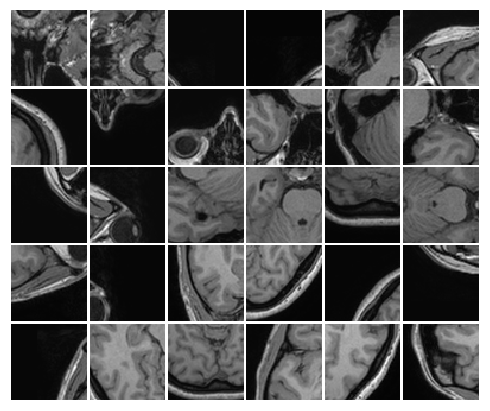

In [4]:
fig = matshow3d(t1, show=True, cmap='gray',figsize=(5,5))

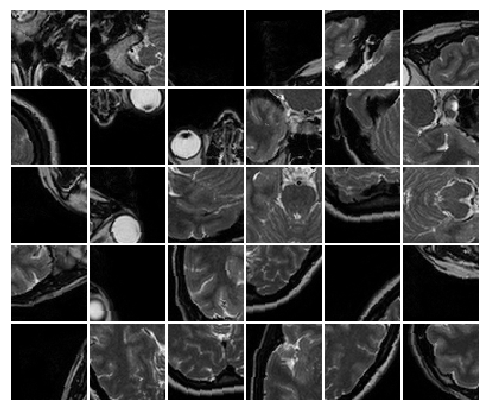

In [5]:
fig = matshow3d(t2, show=True, cmap='gray',figsize=(5,5))

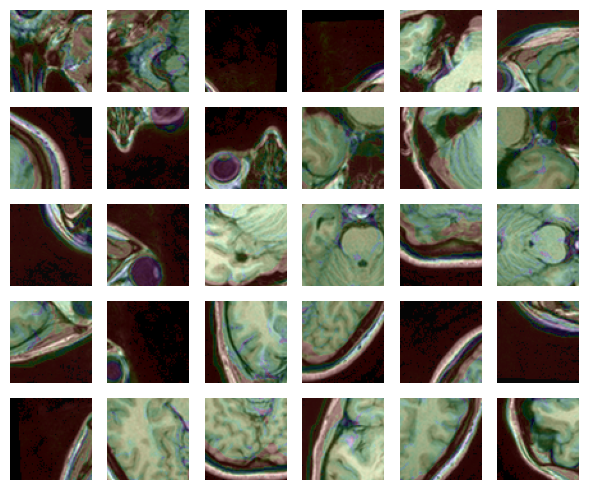

In [6]:
fig = plot_blended_images(t1,t2) # plot blended images (Use this function to plot the blended images of size: torch.Size([30, 1, 64, 64]) torch.Size([30, 1, 64, 64]))

## Process validation and test dataset

- Note: Validation and Test dataset has no misalignment

In [11]:

root_dir = 'datasets/IXI/val'
t1s = sorted(glob.glob(os.path.join(root_dir, "t1*.nii.gz")))
t2s = sorted(glob.glob(os.path.join(root_dir, "t2*.nii.gz")))

imtrans = Compose(
    [
        LoadImage(image_only=True, ensure_channel_first=True),
    ]
)

segtrans = Compose(
    [
        LoadImage(image_only=True, ensure_channel_first=True),
    ]
)

ds = ArrayDataset(t1s, imtrans, t2s, segtrans)

loader = torch.utils.data.DataLoader(ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())
im1, im2 = first(loader)
print(im1.shape, im2.shape)

# Save training dataset to numpy array file (Slice by Slice)
for idx, (im1, im2) in tqdm(enumerate(loader), desc='3d image'):
    nslice = im1.shape[-1]
    for sl in range(nslice):
        np.save(f'datasets/IXI/val/t1_{idx}_{sl}.npy', im1[...,sl].squeeze())
        np.save(f'datasets/IXI/val/t2_{idx}_{sl}.npy', im2[...,sl].squeeze())
        

torch.Size([1, 1, 256, 256, 91]) torch.Size([1, 1, 256, 256, 91])


3d image: 5it [00:01,  4.37it/s]


In [12]:

root_dir = 'datasets/IXI/test'
t1s = sorted(glob.glob(os.path.join(root_dir, "t1*.nii.gz")))
t2s = sorted(glob.glob(os.path.join(root_dir, "t2*.nii.gz")))

imtrans = Compose(
    [
        LoadImage(image_only=True, ensure_channel_first=True),
    ]
)

segtrans = Compose(
    [
        LoadImage(image_only=True, ensure_channel_first=True),
    ]
)

ds = ArrayDataset(t1s, imtrans, t2s, segtrans)

loader = torch.utils.data.DataLoader(ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())
im1, im2 = first(loader)
print(im1.shape, im2.shape)

# Save training dataset to numpy array file (Slice by Slice)
for idx, (im1, im2) in tqdm(enumerate(loader), desc='3d image'):
    nslice = im1.shape[-1]
    for sl in range(nslice):
        np.save(f'datasets/IXI/test/t1_{idx}_{sl}.npy', im1[...,sl].squeeze())
        np.save(f'datasets/IXI/test/t2_{idx}_{sl}.npy', im2[...,sl].squeeze())
        

torch.Size([1, 1, 256, 256, 91]) torch.Size([1, 1, 256, 256, 91])


3d image: 10it [00:02,  4.95it/s]


## TODO: make the whole code into a single code (that saves auxilary images)